In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
from scipy.sparse import csc_matrix, csr_matrix, hstack, vstack
from torch import sparse_csc_tensor
import cupy as cp
import torchvision.models as models
import json
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [ ]:
def padding_matrix_csc(rows, columns, padding):
    total_rows = (rows + 2 * padding) * (columns + 2 * padding)
    total_columns = rows * columns
    row_inds = np.zeros(total_columns)
    col_inds = np.zeros(total_columns)
    values = np.ones(total_columns, dtype=int)
    for n in range(1, rows+1):
      row_start = (columns + 2 * padding)*(n+padding-1) + padding
      row_end = row_start + columns
      column_start = columns * (n-1)
      column_end =  columns * n
      row_inds[columns*(n-1):columns*n] = np.arange(row_start, row_end)
      col_inds[columns*(n-1):columns*n] = np.arange(column_start, column_end)
    return csc_matrix((values, (row_inds, col_inds)), shape=(total_rows, total_columns))

def padding_matrix_csr(rows, columns, padding):
    total_rows = (rows + 2 * padding) * (columns + 2 * padding)
    total_columns = rows * columns
    row_inds = np.zeros(total_columns)
    col_inds = np.zeros(total_columns)
    values = np.ones(total_columns, dtype=int)
    for n in range(1, rows+1):
      row_start = (columns + 2 * padding)*(n+padding-1) + padding
      row_end = row_start + columns
      column_start = columns * (n-1)
      column_end =  columns * n
      row_inds[columns*(n-1):columns*n] = np.arange(row_start, row_end)
      col_inds[columns*(n-1):columns*n] = np.arange(column_start, column_end)
    return csc_matrix((values, (row_inds, col_inds)), shape=(total_rows, total_columns))

In [ ]:
def padding_matrix_csr_gpu(rows, columns, padding):
    total_rows = (rows + 2 * padding) * (columns + 2 * padding)
    total_columns = rows * columns
    row_inds = cp.zeros(total_columns)
    col_inds = cp.zeros(total_columns)
    values = cp.ones(total_columns)
    for n in range(1, rows+1):
      row_start = (columns + 2 * padding)*(n+padding-1) + padding
      row_end = row_start + columns
      column_start = columns * (n-1)
      column_end =  columns * n
      row_inds[columns*(n-1):columns*n] = cp.arange(row_start, row_end)
      col_inds[columns*(n-1):columns*n] = cp.arange(column_start, column_end)
    return cp.sparse.csr_matrix((values, (row_inds, col_inds)), shape=(total_rows, total_columns))

def padding_matrix_csc_gpu(rows, columns, padding):
    total_rows = (rows + 2 * padding) * (columns + 2 * padding)
    total_columns = rows * columns
    row_inds = cp.zeros(total_columns)
    col_inds = cp.zeros(total_columns)
    values = cp.ones(total_columns)
    for n in range(1, rows+1):
      row_start = (columns + 2 * padding)*(n+padding-1) + padding
      row_end = row_start + columns
      column_start = columns * (n-1)
      column_end =  columns * n
      row_inds[columns*(n-1):columns*n] = cp.arange(row_start, row_end)
      col_inds[columns*(n-1):columns*n] = cp.arange(column_start, column_end)
    return cp.sparse.csc_matrix((values, (row_inds, col_inds)), shape=(total_rows, total_columns))

In [ ]:
def toeplitz_convolution_csc(kernel, k, m, n, s, p): # k = kernel size, m = rows, n = columns, s = stride, p = padding
  w = n+2*p - k
  h = m+2*p - k
  R_rows = (w)//s + 1
  block_columns = (h)//s + 1
  vert_remainder = h - s*(block_columns - 1)
  R = [csc_matrix([sum([[0]*s*i + list(kernel[j])+[0]*(w-s*i) for j in range(k)], []) for i in range(R_rows)])]
  vert0 = [csc_matrix((R_rows, (w+k)*s))]
  end0 = [csc_matrix((R_rows, (w+k)*vert_remainder))]
  blocks = [hstack(vert0*l + R + vert0*(block_columns-1-l)+end0) for l in range(block_columns)]
  block_matrix = vstack(blocks)
  return block_matrix

def toeplitz_convolution_csr(kernel, k, m, n, s, p): # k = kernel size, m = rows, n = columns, s = stride, p = padding
  w = n+2*p - k
  h = m+2*p - k
  R_rows = (w)//s + 1
  block_columns = (h)//s + 1
  vert_remainder = h - s*(block_columns - 1)
  R = [csr_matrix([sum([[0]*s*i + list(kernel[j])+[0]*(w-s*i) for j in range(k)], []) for i in range(R_rows)])]
  vert0 = [csr_matrix((R_rows, (w+k)*s))]
  end0 = [csr_matrix((R_rows, (w+k)*vert_remainder))]
  blocks = [hstack(vert0*l + R + vert0*(block_columns-1-l)+end0) for l in range(block_columns)]
  block_matrix = vstack(blocks)
  return block_matrix

In [ ]:
def toeplitz_convolution_csc_gpu(kernel, k, m, n, s, p): # k = kernel size, m = rows, n = columns, s = stride, p = padding
  w = n+2*p - k
  h = m+2*p - k
  R_rows = (w)//s + 1
  block_columns = (h)//s + 1
  vert_remainder = h - s*(block_columns - 1)
  R = [cp.sparse.csc_matrix(cp.array([sum([[0]*s*i + list(kernel.get()[j])+[0]*(w-s*i) for j in range(k)], []) for i in range(R_rows)]))]
  vert0 = [cp.sparse.csc_matrix((R_rows, (w+k)*s))]
  end0 = [cp.sparse.csc_matrix((R_rows, (w+k)*vert_remainder))]
  blocks = [cp.sparse.hstack(vert0*l + R + vert0*(block_columns-1-l)+end0) for l in range(block_columns)]
  block_matrix = cp.sparse.vstack(blocks)
  return block_matrix

def toeplitz_convolution_csr_gpu(kernel, k, m, n, s, p): # k = kernel size, m = rows, n = columns, s = stride, p = padding
  w = n+2*p - k
  h = m+2*p - k
  R_rows = (w)//s + 1
  block_columns = (h)//s + 1
  vert_remainder = h - s*(block_columns - 1)
  R = [cp.sparse.csr_matrix(cp.array([sum([[0]*s*i + list(kernel.get()[j])+[0]*(w-s*i) for j in range(k)], []) for i in range(R_rows)]))]
  vert0 = [cp.sparse.csr_matrix((R_rows, (w+k)*s))]
  end0 = [cp.sparse.csr_matrix((R_rows, (w+k)*vert_remainder))]
  blocks = [cp.sparse.hstack(vert0*l + R + vert0*(block_columns-1-l)+end0) for l in range(block_columns)]
  block_matrix = cp.sparse.vstack(blocks)
  return block_matrix

In [ ]:
def transformation_matrix_csc(kernel, rows, columns, stride, padding):
    pad_matrix = padding_matrix_csc(rows, columns, padding)
    conv_matrix = toeplitz_convolution_csc(kernel, kernel.shape[0], rows, columns, stride, padding)
    T_matrix = conv_matrix @ pad_matrix
    return T_matrix

def transformation_matrix_csr(kernel, rows, columns, stride, padding):
    pad_matrix = padding_matrix_csr(rows, columns, padding)
    conv_matrix = toeplitz_convolution_csr(kernel, kernel.shape[0], rows, columns, stride, padding)
    T_matrix = conv_matrix @ pad_matrix
    return T_matrix

In [ ]:
def transformation_csc_gpu(kernel, rows, columns, stride, padding):
    pad_matrix = padding_matrix_csc_gpu(rows, columns, padding)
    conv_matrix = toeplitz_convolution_csc_gpu(kernel, kernel.shape[0], rows, columns, stride, padding)
    T_matrix = conv_matrix @ pad_matrix
    return T_matrix

def transformation_csr_gpu(kernel, rows, columns, stride, padding):
    pad_matrix = padding_matrix_csr_gpu(rows, columns, padding)
    conv_matrix = toeplitz_convolution_csr_gpu(kernel, kernel.shape[0], rows, columns, stride, padding)
    T_matrix = conv_matrix @ pad_matrix
    return T_matrix

In [ ]:
def test_algo_csc(kernel_size, rows, columns, stride, padding, num_trials):
    in_data = np.random.normal(size=(rows, columns))
    kernel = np.random.normal(size=(kernel_size, kernel_size))
    T_matrix = transformation_matrix_csc(kernel, rows, columns, stride, padding)
    in_tensor = torch.tensor(in_data).unsqueeze(0).unsqueeze(0)
    kernel_tensor = torch.tensor(kernel).unsqueeze(0).unsqueeze(0)

    times_mult = []
    for i in range(num_trials):
        start = time.perf_counter()
        in_vec = in_data.ravel()
        trans_vec = T_matrix @ in_vec
        out_data = trans_vec.reshape((rows-kernel_size+2*padding)//stride+1, \
                                     (columns-kernel_size+2*padding)//stride+1)
        end = time.perf_counter()
        times_mult.append(end - start)

    times_conv2d = []
    for i in range(num_trials):
        start = time.perf_counter()
        out_tensor = nn.functional.conv2d(in_tensor, kernel_tensor, stride=stride, padding=padding).squeeze()
        end = time.perf_counter()
        times_conv2d.append(end - start)

    return times_mult, times_conv2d

def test_algo_csr(kernel_size, rows, columns, stride, padding, num_trials):
    in_data = np.random.normal(size=(rows, columns))
    kernel = np.random.normal(size=(kernel_size, kernel_size))
    T_matrix = transformation_matrix_csr(kernel, rows, columns, stride, padding)
    in_tensor = torch.tensor(in_data).unsqueeze(0).unsqueeze(0)
    kernel_tensor = torch.tensor(kernel).unsqueeze(0).unsqueeze(0)

    times_mult = []
    for i in range(num_trials):
        start = time.perf_counter()
        in_vec = in_data.ravel()
        trans_vec = T_matrix @ in_vec
        out_data = trans_vec.reshape((rows-kernel_size+2*padding)//stride+1, \
                                     (columns-kernel_size+2*padding)//stride+1)
        end = time.perf_counter()
        times_mult.append(end - start)

    return times_mult

In [ ]:
def test_csc_gpu_versions(kernel_size, rows, columns, stride, padding, num_trials):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_data = cp.random.normal(size=(rows, columns))
    kernel = cp.random.normal(size=(kernel_size, kernel_size))
    T_matrix = transformation_csc_gpu(kernel, rows, columns, stride, padding)
    in_tensor = torch.tensor(in_data).unsqueeze(0).unsqueeze(0).to(device)
    kernel_tensor = torch.tensor(kernel).unsqueeze(0).unsqueeze(0).to(device)

    start = cp.cuda.Event()
    end = cp.cuda.Event()
    times_gpu = []
    for i in range(num_trials):
        start.record()
        in_vec = in_data.ravel()
        trans_vec = T_matrix @ in_vec
        out_data = trans_vec.reshape((rows-kernel_size+2*padding)//stride+1, \
                                     (columns-kernel_size+2*padding)//stride+1)
        end.record()
        cp.cuda.Stream.null.synchronize()
        times_gpu.append(cp.cuda.get_elapsed_time(start, end))

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    times_conv2d_gpu = []
    for i in range(num_trials):
        start.record()
        out_tensor = nn.functional.conv2d(in_tensor, kernel_tensor, stride=stride, padding=padding).squeeze()
        end.record()
        torch.cuda.synchronize()
        times_conv2d_gpu.append(start.elapsed_time(end))

    return times_gpu, times_conv2d_gpu

def test_conv2d_gpu(kernel_size, rows, columns, stride, padding, num_trials):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_data = np.random.normal(size=(rows, columns))
    kernel = np.random.normal(size=(kernel_size, kernel_size))
    T_matrix = transformation_matrix_csc(kernel, rows, columns, stride, padding)
    in_tensor = torch.tensor(in_data).unsqueeze(0).unsqueeze(0).to(device)
    kernel_tensor = torch.tensor(kernel).unsqueeze(0).unsqueeze(0).to(device)

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    times_conv2d_gpu = []
    for i in range(num_trials):
        start.record()
        out_tensor = nn.functional.conv2d(in_tensor, kernel_tensor, stride=stride, padding=padding).squeeze()
        end.record()
        torch.cuda.synchronize()
        times_conv2d_gpu.append(start.elapsed_time(end))

    return times_conv2d_gpu

def test_csr_gpu_versions(kernel_size, rows, columns, stride, padding, num_trials):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_data = cp.random.normal(size=(rows, columns))
    kernel = cp.random.normal(size=(kernel_size, kernel_size))
    T_matrix = transformation_csr_gpu(kernel, rows, columns, stride, padding)
    in_tensor = torch.tensor(in_data).unsqueeze(0).unsqueeze(0).to(device)
    kernel_tensor = torch.tensor(kernel).unsqueeze(0).unsqueeze(0).to(device)

    start = cp.cuda.Event()
    end = cp.cuda.Event()
    times_gpu = []
    for i in range(num_trials):
        start.record()
        in_vec = in_data.ravel()
        trans_vec = T_matrix @ in_vec
        out_data = trans_vec.reshape((rows-kernel_size+2*padding)//stride+1, \
                                     (columns-kernel_size+2*padding)//stride+1)
        end.record()
        cp.cuda.Stream.null.synchronize()
        times_gpu.append(cp.cuda.get_elapsed_time(start, end))

    return times_gpu

def csc_to_csc_tensor(csc_matrix_np):
    # Extract data, indices, and indptr from the NumPy CSC matrix
    values = torch.tensor(csc_matrix_np.data, dtype=torch.float32)
    indices = torch.tensor(csc_matrix_np.indices, dtype=torch.int64)
    indptr = torch.tensor(csc_matrix_np.indptr, dtype=torch.int64)

    # Create the PyTorch sparse CSC tensor
    sparse_tensor = torch.sparse_csc_tensor(indptr, indices, values, size=csc_matrix_np.shape, dtype=torch.float64)

    return sparse_tensor

def test_torch_sparse_version(kernel_size, rows, columns, stride, padding, num_trials):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    in_data = np.random.normal(size=(rows, columns))
    kernel = np.random.normal(size=(kernel_size, kernel_size))
    T_matrix = transformation_matrix_csc(kernel, rows, columns, stride, padding)
    T_tensor = csc_to_csc_tensor(T_matrix).to_sparse_csr().to(device)
    in_tensor = torch.tensor(in_data).to(device)

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    times_gpu = []
    for i in range(num_trials):
        start.record()
        in_vec = in_tensor.ravel()
        trans_vec = T_tensor @ in_vec
        out_data = trans_vec.reshape((rows-kernel_size+2*padding)//stride+1, \
                                        (columns-kernel_size+2*padding)//stride+1)
        end.record()
        torch.cuda.synchronize()
        times_gpu.append(start.elapsed_time(end))

    return times_gpu

In [ ]:
# Example
np.random.seed(0)

rows = 10
columns = 10
kernel_size = 7
stride = 1
padding = 1
num_trials = 10000

In [ ]:
times_mult = test_torch_sparse_version(kernel_size, rows, columns, stride, padding, num_trials)
print(f"Mult (Torch GPU CSR): {np.mean(times_mult)/1000} +/- {np.std(times_mult) /1000 / np.sqrt(num_trials)}")

C:\Users\Small\AppData\Local\Temp\ipykernel_29680\1681759434.py:64: UserWarning: Sparse CSC tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at  ..\aten\src\ATen\SparseCsrTensorImpl.cpp:68.)
  sparse_tensor = torch.sparse_csc_tensor(indptr, indices, values, size=csc_matrix_np.shape, dtype=torch.float64)


Mult (Torch GPU CSR): 0.00014317712341565639 +/- 6.942796442863736e-05


In [ ]:
times_gpu, times_torch_gpu = test_csc_gpu_versions(kernel_size, rows, columns, stride, padding, num_trials)
print(f"Mult (CSC) GPU: {np.mean(times_gpu)/1000} +/- {np.std(times_gpu)/1000 / np.sqrt(num_trials)}")
print(f"Torch Conv2D GPU: {np.mean(times_torch_gpu)/1000} +/- {np.std(times_torch_gpu) /1000/ np.sqrt(num_trials)}")

times_gpu = test_csr_gpu_versions(kernel_size, rows, columns, stride, padding, num_trials)
print(f"Mult (CSR) GPU: {np.mean(times_gpu)/1000} +/- {np.std(times_gpu)/1000 / np.sqrt(num_trials)}")

Mult (CSC) GPU: 0.00010818526726663112 +/- 6.045055284488943e-07
Torch Conv2D GPU: 0.00023251461565382777 +/- 0.00013607804855333646
Mult (CSR) GPU: 0.00010163959937393665 +/- 4.0772921903937394e-07


In [ ]:
times_mult, times_conv2d = test_algo_csc(kernel_size, rows, columns, stride, padding, num_trials)
print(f"Mult (CSC): {np.mean(times_mult)} +/- {np.std(times_mult) / np.sqrt(num_trials)}")
print(f"Torch Conv2D: {np.mean(times_conv2d)} +/- {np.std(times_conv2d) / np.sqrt(num_trials)}")

times_mult = test_algo_csr(kernel_size, rows, columns, stride, padding, num_trials)
print(f"Mult (CSR): {np.mean(times_mult)} +/- {np.std(times_mult) / np.sqrt(num_trials)}")

Mult (CSC): 6.258669969975017e-06 +/- 1.9232662000061114e-08
Torch Conv2D: 2.3481610002636444e-05 +/- 2.6768158110637605e-07
Mult (CSR): 6.816650034306804e-06 +/- 2.457078346015312e-08


In [ ]:
def extract_feature_extractor_details(model, input_tensor):
    layer_details = []

    # Hook function to capture input and output sizes
    def hook_fn(module, input, output):
        layer_info = {}
        layer_info['Layer Name'] = module._name
        layer_info['Layer Type'] = type(module).__name__

        # Handle input and output size extraction
        if isinstance(input, (list, tuple)):
            layer_info['Input Size'] = [tuple(tensor.shape) for tensor in input if hasattr(tensor, 'shape')]
        else:
            layer_info['Input Size'] = [tuple(input.shape)]

        if hasattr(output, 'shape'):
            layer_info['Output Size'] = tuple(output.shape)
        else:
            layer_info['Output Size'] = 'N/A'

        # Exclude layers that don't change dimensionality
        if layer_info['Input Size'] == [layer_info['Output Size']]:
            return

        # Add specific details for certain layer types
        if isinstance(module, nn.Conv2d):
            layer_info['Kernel Size'] = module.kernel_size
            layer_info['Stride'] = module.stride
            layer_info['Padding'] = module.padding
        elif isinstance(module, nn.MaxPool2d) or isinstance(module, nn.AvgPool2d):
            layer_info['Kernel Size'] = module.kernel_size
            layer_info['Stride'] = module.stride
            layer_info['Padding'] = module.padding
        elif isinstance(module, nn.AdaptiveAvgPool2d):
            layer_info['Kernel Size'] = 'N/A'
            layer_info['Stride'] = 'N/A'
            layer_info['Padding'] = 'N/A'

        layer_details.append(layer_info)

    # Register hooks only for layers in the feature extractor
    hooks = []
    for name, layer in model.features.named_modules():  # Restrict to the feature extractor
        if isinstance(layer, (nn.Conv2d, nn.MaxPool2d, nn.AvgPool2d, nn.AdaptiveAvgPool2d)):
            layer._name = name  # Add name attribute for identification
            hooks.append(layer.register_forward_hook(hook_fn))

    # Perform a forward pass to trigger hooks
    model.eval()
    with torch.no_grad():
        features_output = model.features(input_tensor)

    # Remove hooks after use
    for hook in hooks:
        hook.remove()

    return layer_details

In [ ]:
# Load the DenseNet121 model from torchvision
model = models.densenet121()
num_trials = 10000

# Create a sample input tensor
input_tensor = torch.randn(1, 3, 224, 224)

# Extract layer details for the feature extractor (excluding classifier layers)
feature_layer_details = extract_feature_extractor_details(model, input_tensor)

data_dict = {}

# Print the details
for detail in feature_layer_details:
    print(detail["Layer Name"])
    data_dict[detail["Layer Name"]] = {}

    rows, columns = detail['Input Size'][0][-2:]
    if isinstance(detail['Kernel Size'], tuple):
        kernel_size = detail['Kernel Size'][0]
    else:
        kernel_size = detail['Kernel Size']

    if isinstance(detail['Stride'], tuple):
        stride = detail['Stride'][0]
    else:
        stride = detail['Stride']

    if isinstance(detail['Padding'], tuple):
        padding = detail['Padding'][0]
    else:
        padding = detail['Padding']

    times_mult = test_torch_sparse_version(kernel_size, rows, columns, stride, padding, num_trials)
    print(f"Mult (Torch GPU CSR): {np.mean(times_mult)/1000} +/- {np.std(times_mult) /1000 / np.sqrt(num_trials)}")
    data_dict[detail["Layer Name"]]["Mult (Torch GPU CSR)"] = times_mult

    times_gpu, times_torch_gpu = test_csc_gpu_versions(kernel_size, rows, columns, stride, padding, num_trials)
    print(f"Mult (CSC) GPU: {np.mean(times_gpu)/1000} +/- {np.std(times_gpu)/1000 / np.sqrt(num_trials)}")
    print(f"Torch Conv2D GPU: {np.mean(times_torch_gpu)/1000} +/- {np.std(times_torch_gpu) /1000/ np.sqrt(num_trials)}")
    data_dict[detail["Layer Name"]]["Mult (CSC) GPU"] = times_gpu
    data_dict[detail["Layer Name"]]["Torch Conv2D GPU"] = times_torch_gpu

    times_gpu = test_csr_gpu_versions(kernel_size, rows, columns, stride, padding, num_trials)
    print(f"Mult (CSR) GPU: {np.mean(times_gpu)/1000} +/- {np.std(times_gpu)/1000 / np.sqrt(num_trials)}")

    data_dict[detail["Layer Name"]]["Mult (CSR) GPU"] = times_gpu

    times_mult, times_conv2d = test_algo_csc(kernel_size, rows, columns, stride, padding, num_trials)
    print(f"Mult (CSC): {np.mean(times_mult)} +/- {np.std(times_mult) / np.sqrt(num_trials)}")
    print(f"Torch Conv2D: {np.mean(times_conv2d)} +/- {np.std(times_conv2d) / np.sqrt(num_trials)}")
    data_dict[detail["Layer Name"]]["Mult (CSC)"] = times_mult
    data_dict[detail["Layer Name"]]["Torch Conv2D"] = times_conv2d

    times_mult = test_algo_csr(kernel_size, rows, columns, stride, padding, num_trials)
    print(f"Mult (CSR): {np.mean(times_mult)} +/- {np.std(times_mult) / np.sqrt(num_trials)}")
    data_dict[detail["Layer Name"]]["Mult (CSR)"] = times_mult
    print("="*50)
    print()

conv0
Mult (Torch GPU CSR): 0.0001353552325345576 +/- 1.7309055377087371e-06
Mult (CSC) GPU: 0.00015934853142052889 +/- 3.995117896884414e-07
Torch Conv2D GPU: 9.221489494163543e-05 +/- 3.7119559270618395e-07
Mult (CSR) GPU: 0.00016146411567255855 +/- 3.849158726757164e-07
Mult (CSC): 0.0005728276099813229 +/- 1.2449583502291726e-06
Torch Conv2D: 0.0005044588200253202 +/- 8.398785487605175e-07
Mult (CSR): 0.0004853223099620664 +/- 6.311532913733551e-07

pool0
Mult (Torch GPU CSR): 7.177400328703225e-05 +/- 1.8379175954620288e-07
Mult (CSC) GPU: 9.276917675733566e-05 +/- 2.417419600492619e-07
Torch Conv2D GPU: 8.546651972634718e-05 +/- 1.790746391885471e-07
Mult (CSR) GPU: 9.37749495703727e-05 +/- 2.548210498022122e-07
Mult (CSC): 3.557995002702228e-05 +/- 6.953065801962182e-08
Torch Conv2D: 5.852327000029618e-05 +/- 1.6982735407714947e-07
Mult (CSR): 2.887716999684926e-05 +/- 8.862293695181739e-08

denseblock1.denselayer1.conv1
Mult (Torch GPU CSR): 8.004024361874907e-05 +/- 3.14921358

In [ ]:
def save_dict_to_file(dictionary, file_path):
    """
    Saves a dictionary to a text file.

    Parameters:
    - dictionary (dict): The dictionary to be saved.
    - file_path (str): The path to the file where the dictionary will be saved.
    """
    try:
        with open(file_path, 'w') as file:
            json.dump(dictionary, file, indent=4)
        print(f"Dictionary successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the dictionary: {e}")

In [ ]:
save_dict_to_file(data_dict, "DensenetData_AlgoPaper.txt")

Dictionary successfully saved to DensenetData_AlgoPaper.txt


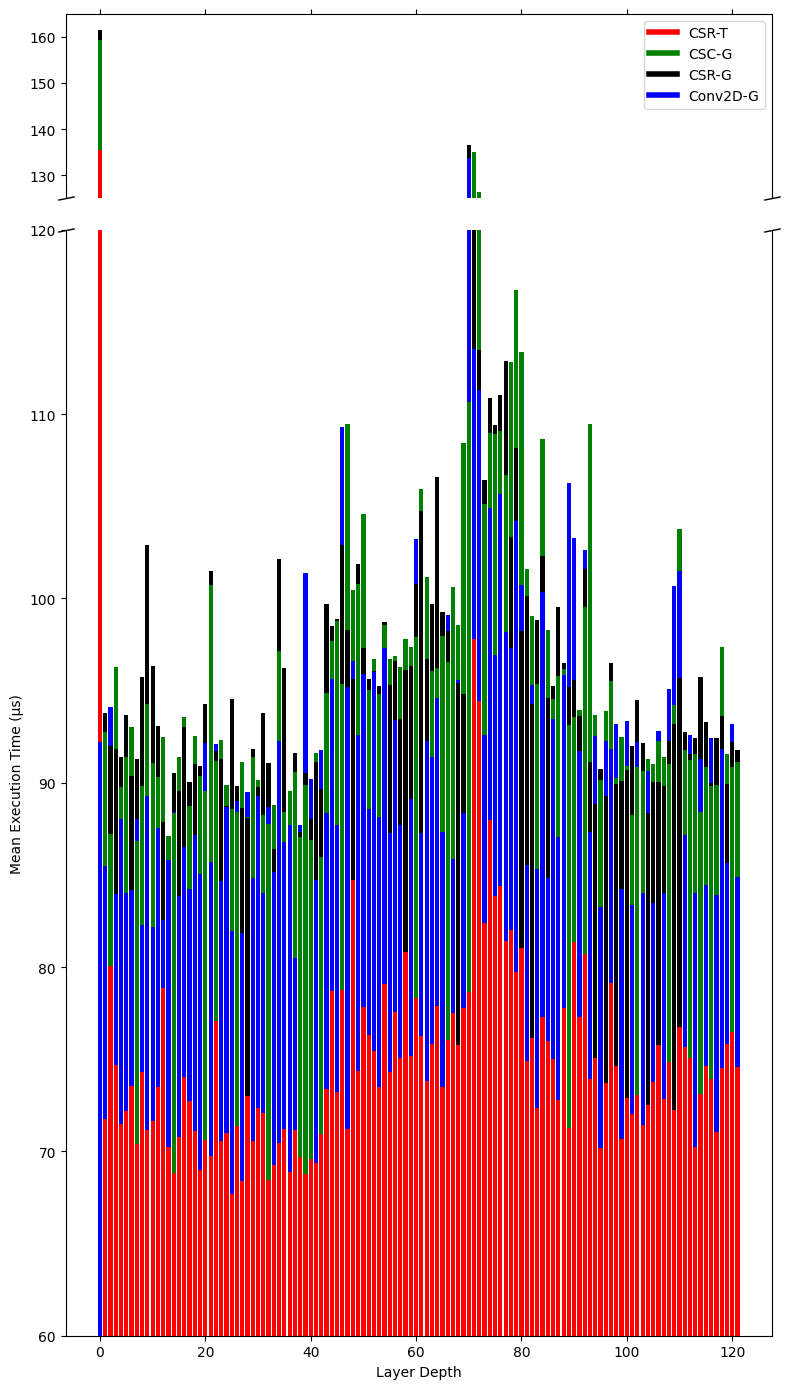

In [ ]:
# Sample data (your existing data)
data = data_dict

# Calculate mean execution times
layers = list(data.keys())
algorithms = list(next(iter(data.values())).keys())  # Get algorithm names from the first layer
algorithms = [algo for algo in algorithms if "GPU" in algo]

# Prepare mean execution times
mean_times = {algo: [] for algo in algorithms}
for layer in layers:
    for algo in algorithms:
        mean_times[algo].append(np.mean(data[layer][algo]) * 1000)

# Plot stacked bar chart
x = np.arange(len(layers))  # X-axis positions for the layers
bar_width = 0.8

# Initialize the plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 14), gridspec_kw={'height_ratios': [1, 6]})  # Two axes with shared x-axis
fig.subplots_adjust(hspace=0.05)  # Adjust space between Axes

bottoms = np.zeros(len(layers))  # Track the bottom of the stacks

colors = ["red", "green", "blue", "black"]  # Use distinct colors
colors_dict = {algorithms[i] : colors[i] for i in range(len(algorithms))}

# Plot stacked bars on the second axis (ax2)
for i, layer in enumerate(layers):
    plot_times = []
    for algo in algorithms:
        plot_times.append((mean_times[algo][i], algo))
    plot_times = sorted(plot_times, key=lambda x: x[0])
    plot_times.reverse()

    for k in range(len(plot_times)):
        ax2.bar(
            i,
            plot_times[k][0],
            bar_width,
            color=colors_dict[plot_times[k][1]],
            label=plot_times[k][1],
        )
        ax1.bar(
            i,
            plot_times[k][0],
            bar_width,
            color=colors_dict[plot_times[k][1]],
            label=plot_times[k][1],
        )

# Custom legend
custom_lines = [Line2D([0], [0], color=c, lw=4) for c in colors]
ax1.legend([custom_lines[0], custom_lines[1], custom_lines[3], custom_lines[2]], ["CSR-T", "CSC-G", "CSR-G", "Conv2D-G"])

# Set axis labels and title
ax2.set_xlabel("Layer Depth")
ax2.set_ylabel("Mean Execution Time (µs)")

# Set y-limits for the two axes
ax1.set_ylim(125, 165)  # Outliers or higher values
ax2.set_ylim(60, 120)    # Most of the data

# Hide the spines between ax1 and ax2
ax1.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Hide top tick labels
ax2.xaxis.tick_bottom()

# Slanted lines for the y-axis break
d = 0.2  # Proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)  # Line at top of ax1
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)  # Line at bottom of ax2

# Show the plot
plt.tight_layout()
plt.savefig("DenseNet121_GPU_Algos.png", dpi=600)
plt.show()

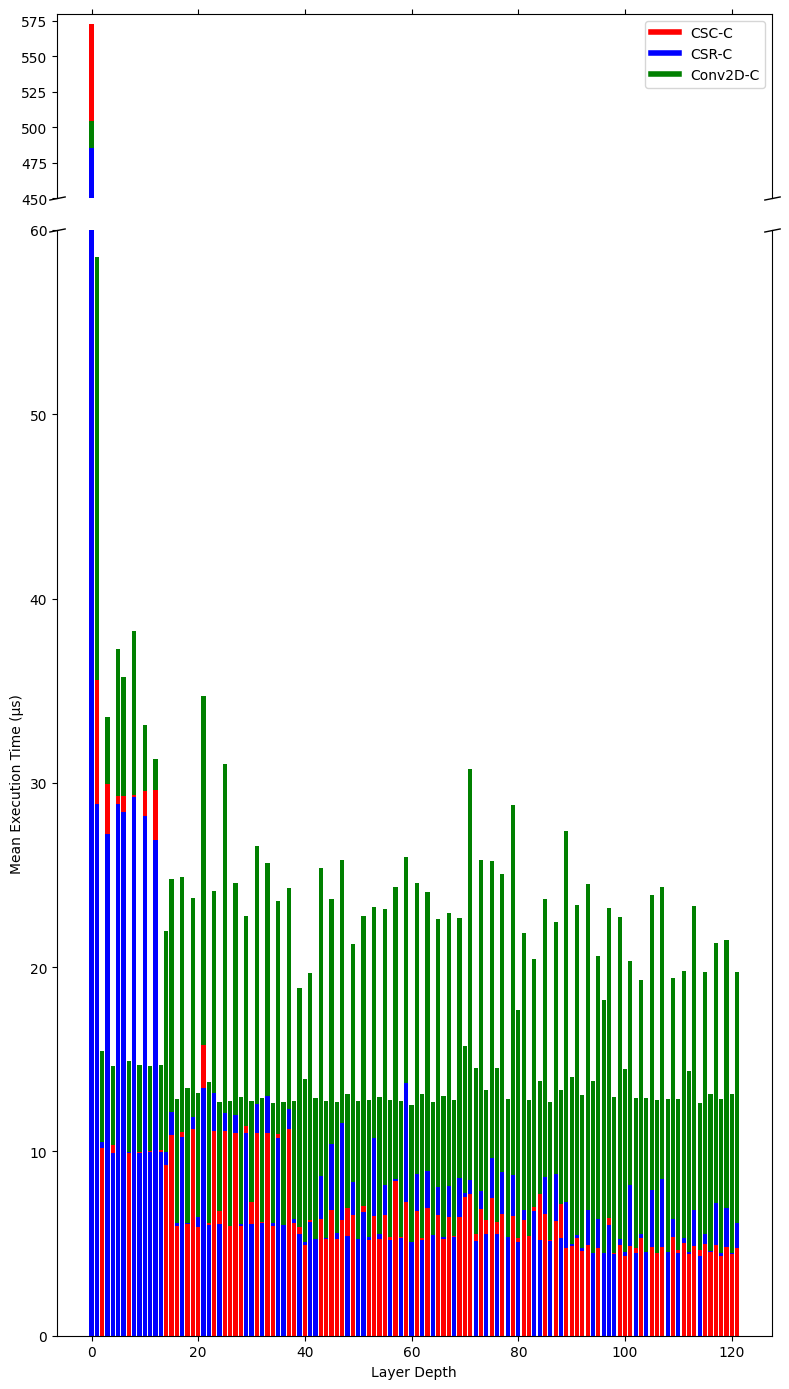

In [ ]:
# Sample data (your existing data)
data = data_dict

# Calculate mean execution times
layers = list(data.keys())
algorithms = list(next(iter(data.values())).keys())  # Get algorithm names from the first layer
algorithms = [algo for algo in algorithms if "GPU" not in algo]

# Prepare mean execution times
mean_times = {algo: [] for algo in algorithms}
for layer in layers:
    for algo in algorithms:
        mean_times[algo].append(np.mean(data[layer][algo]) * 1000000)

# Plot stacked bar chart
x = np.arange(len(layers))  # X-axis positions for the layers
bar_width = 0.8

# Initialize the plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 14), gridspec_kw={'height_ratios': [1, 6]})  # Two axes with shared x-axis
fig.subplots_adjust(hspace=0.05)  # Adjust space between Axes

bottoms = np.zeros(len(layers))  # Track the bottom of the stacks

colors = ["red", "green", "blue"]  # Use distinct colors
colors_dict = {algorithms[i]: colors[i] for i in range(len(algorithms))}

# Plot stacked bars on the second axis (ax2)
for i, layer in enumerate(layers):
    plot_times = []
    for algo in algorithms:
        plot_times.append((mean_times[algo][i], algo))
    plot_times = sorted(plot_times, key=lambda x: x[0])
    plot_times.reverse()

    for k in range(len(plot_times)):
        ax2.bar(
            i,
            plot_times[k][0],
            bar_width,
            color=colors_dict[plot_times[k][1]],
            label=plot_times[k][1],
        )
        ax1.bar(
            i,
            plot_times[k][0],
            bar_width,
            color=colors_dict[plot_times[k][1]],
            label=plot_times[k][1],
        )

# Custom legend
custom_lines = [Line2D([0], [0], color=c, lw=4) for c in colors]
ax1.legend([custom_lines[0], custom_lines[2], custom_lines[1]], ["CSC-C", "CSR-C", "Conv2D-C"])

# Set axis labels and title
ax2.set_xlabel("Layer Depth")
ax2.set_ylabel("Mean Execution Time (µs)")

# Set y-limits for the two axes
ax1.set_ylim(450, 580)  # Outliers or higher values
ax2.set_ylim(0, 60)    # Most of the data

# Hide the spines between ax1 and ax2
ax1.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # Hide top tick labels
ax2.xaxis.tick_bottom()

# Slanted lines for the y-axis break
d = 0.2  # Proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)  # Line at top of ax1
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)  # Line at bottom of ax2

# Show the plot
plt.tight_layout()
plt.savefig("DenseNet121_CPU_Algos.png", dpi=600)
plt.show()

In [ ]:
# Print the details
info = []
for detail in feature_layer_details:
    rows, columns = detail['Input Size'][0][-2:]
    if isinstance(detail['Kernel Size'], tuple):
        kernel_size = detail['Kernel Size'][0]
    else:
        kernel_size = detail['Kernel Size']

    if isinstance(detail['Stride'], tuple):
        stride = detail['Stride'][0]
    else:
        stride = detail['Stride']

    if isinstance(detail['Padding'], tuple):
        padding = detail['Padding'][0]
    else:
        padding = detail['Padding']

    info.append((rows, columns, kernel_size, stride, padding))

info = list(set(info))
info = sorted(info, key = lambda x: x[0])
info.reverse()
for item in info:
    print(item)
    print("="*50)

(224, 224, 7, 2, 3)
(112, 112, 3, 2, 1)
(56, 56, 3, 1, 1)
(56, 56, 2, 2, 0)
(56, 56, 1, 1, 0)
(28, 28, 2, 2, 0)
(28, 28, 3, 1, 1)
(28, 28, 1, 1, 0)
(14, 14, 3, 1, 1)
(14, 14, 1, 1, 0)
(14, 14, 2, 2, 0)
(7, 7, 3, 1, 1)
(7, 7, 1, 1, 0)


In [ ]:
# Sample data (your existing data)
with open("DensenetData_AlgoPaper.txt") as f:
    data = json.load(f)

# Calculate mean execution times
layers = list(data.keys())
algorithms = list(next(iter(data.values())).keys())  # Get algorithm names from the first layer

# Prepare mean execution times
algo_times = {algo: [] for algo in algorithms}

for layer in layers:
    for algo in algorithms:
        algo_times[algo].append(data[layer][algo])

for algo in algorithms:
    data_array = np.array(algo_times[algo])
    data_array = np.sum(data_array, axis=0)
    if "GPU" in algo:
        c = 1000
    else:
        c = 1000000
    mean_time, std_error = round(np.mean(data_array) * c, 2), round(np.std(data_array) * c / np.sqrt(data_array.shape[0]), 2)
    print(algo)
    print(f"Mean Execution Time for all Convolutions: {mean_time} +/- {std_error}")
    print("="*50)

Mult (Torch GPU CSR)
Mean Execution Time for all Convolutions: 9187.33 +/- 5.18
Mult (CSC) GPU
Mean Execution Time for all Convolutions: 11740.47 +/- 7.19
Torch Conv2D GPU
Mean Execution Time for all Convolutions: 11143.45 +/- 3.13
Mult (CSR) GPU
Mean Execution Time for all Convolutions: 11737.34 +/- 3.5
Mult (CSC)
Mean Execution Time for all Convolutions: 1535.68 +/- 1.34
Torch Conv2D
Mean Execution Time for all Convolutions: 2871.06 +/- 4.0
Mult (CSR)
Mean Execution Time for all Convolutions: 1506.69 +/- 0.84
